# Recherche de protéines proches d'une cible par mots-clés

Saisir le GENENAME de la protéine d'intêret:

In [15]:
prot_name="BAG3"

Saisir le ou les mots clés des processus biologiques recherchés:
exemple: keyword=["apoptotic","ubiquitin"]

In [16]:
keyword=["apoptotic","ubiquitin","dna"]

Saisir le nombre de protéines, ayant au moins un mot clé dans leur processus biologiques, qui seront sur le graphes

In [17]:
nb_top=20

## Library

In [18]:
#Instal library 
!pip install --upgrade gensim==4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import matplotlib.pyplot as plt
import networkx as nx 
import requests
%pip install Node2Vec
from node2vec import Node2Vec
from gensim.models import Word2Vec

## NEW -> Uniprot library
%pip install bioservices
from bioservices.uniprot import UniProt
u = UniProt(verbose = False)

%pip install goatools
from goatools import obo_parser
import json
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Fonctions

In [20]:
#Convertit le nom d'un gène en l'identifiant UNIPROT correspondant

## NEW
def convert_GENENAME_ACC(id) :
    convert = u.mapping(fr="Gene_Name", to="UniProtKB", query=id)
    for value in range(len(convert)) :
        if convert['results'][value]['to']['organism']['taxonId'] == 9606 :
            print(convert['results'][value]['to']['primaryAccession'])
    return convert['results'][value]['to']['primaryAccession']


"""
def convert_GENENAME_ACC(id):
    url = 'http://www.uniprot.org/mapping/' 
    params = {'from':'GENENAME','to':'ACC','format':'tab','query':id} 
    request = requests.get(url, params)
    return request.text.split("\n")[1].split("\t")[1]
"""

'\ndef convert_GENENAME_ACC(id):\n    url = \'http://www.uniprot.org/mapping/\' \n    params = {\'from\':\'GENENAME\',\'to\':\'ACC\',\'format\':\'tab\',\'query\':id} \n    request = requests.get(url, params)\n    return request.text.split("\n")[1].split("\t")[1]\n'

In [21]:
#Répertorie l'ensemble des keywords présents dans le jeu de protéines
def list_keyword(list_node,dico_bp,go,kw):
    
    list_k=[]
    for i in list_node:
        if i in dico_bp.keys():
            match=False
            for v in dico_bp[i]:
                bp=go[v].name
                for k in kw:
                    if k in bp:
                        match=True
            if match==True and  i not in list_k:
                list_k.append(i)
    return list_k

In [22]:
#Liste des protéines ayant le vecteur le plus proche de la protéine étudiée et ayant le mot clé dans les processus biologiques 
def top_similar(list_k,model,prot_name,top):
    dico_score={}
    final=[]
    for i in list_k:
        score=model.wv.similarity(prot_name,i)
        dico_score[score]=i
    top_list=sorted(dico_score.keys(),reverse=True)
    for s in top_list[:top]:
        final.append((dico_score[s],round(s,3)))
    return final
  

In [23]:
#Ecrit le fichier avec les protéines du graph, leur processus biologiques et leur fonctions moléculaires
def write_top_list(top_list,dico_bp,go):
  with open("liste_proteines.txt","w") as f:
    for i in top_list:
      list_bp=[]
      acc=convert_GENENAME_ACC(i)
      for b in dico_bp[i]:
        if go[b].name not in list_bp:
          list_bp.append(go[b].name)
      list_mf=[]
      r=requests.get(f"http://www.ebi.ac.uk/QuickGO/services/annotation/search?geneProductId={acc}")
      data=r.json()
      for j in data["results"]:
        if j["goAspect"]=="molecular_function" and j["goId"] not in list_mf:
            list_mf.append(go[j["goId"]].name)
      f.write(f"nom :{i}\nProcessus biologique:\n{list_bp}\nFonction moléculaire:\n{list_mf}\n\n")
  files.download("liste_proteines.txt")


In [24]:
#Affiche le graph des protéines avec le chemin le plus court
def display_shortest_path(start_GN,list_prot):
    G1=nx.Graph()
    list_query=[]
    list_node=[]
    for i in list_prot:
        list_query.append(i[0])
        if i[0] not in G1.nodes():
            G1.add_node(i[0])
        if i[0] not in list_node:
            list_node.append(i[0])
        path=nx.shortest_path(G,source=start_GN,target=i[0])
        j=0
        while j<len(path)-1:
            name_p=path[j]
            name_p1=path[j+1]
            if name_p not in G1.nodes():
                G1.add_node(name_p)
            if path[j] not in list_node:
                list_node.append(path[j])
            if name_p1 not in G1.nodes():
                G1.add_node(name_p1)
            if path[j+1] not in list_node:
                list_node.append(path[j+1])
            G1.add_edge(name_p,name_p1)
            j+=1
    color_map=[]
    for node in G1:
        if node==start_GN:
            color_map.append('red')
        elif node in list_query:
            color_map.append("blue")
        else: 
            color_map.append('green')
    list_size=[]
    for s in G1.nodes():
        score=model.wv.similarity(start_GN,s)
        list_size.append(score)
    fig = plt.figure(1, figsize=(40, 20))
    pos = nx.spring_layout(G1,scale=4)
    nx.draw(G1,pos,with_labels=True,node_color=color_map,node_size=[v*15500 for v in list_size],bbox=dict(facecolor="white", edgecolor='black', boxstyle='round,pad=0.2'), font_size=25)
    plt.savefig("Graph_SP.png", format="PNG")
    files.download("Graph_SP.png") 
    return list(G1.nodes())
                

## Appel de fonction

In [25]:
#Création du graph
G=nx.Graph()
with open("/content/gdrive/MyDrive/Search_protein_keywords/edges_string.txt","r") as f:
    for l in f.readlines():
        for m in l.split():
            if m not in G.nodes():
                G.add_node(m)
        G.add_edge(l.split()[0],l.split()[1])
print(len(G.nodes()))
print(len(G.edges()))

16948
290849


In [26]:
#Chargement du model node2vec
model = Word2Vec.load("/content/gdrive/MyDrive/Search_protein_keywords/string_node2vec.model")

In [27]:
#Chargement du dictionnaire goatools pour convertir les goterm
go = obo_parser.GODag("/content/gdrive/MyDrive/Search_protein_keywords/go-basic.obo")

/content/gdrive/MyDrive/Search_protein_keywords/go-basic.obo: fmt(1.2) rel(2022-03-22) 47,103 Terms


## Résultats

taille de la liste:  1809


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

O95817
O14558
P02489
P55957
O60238


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

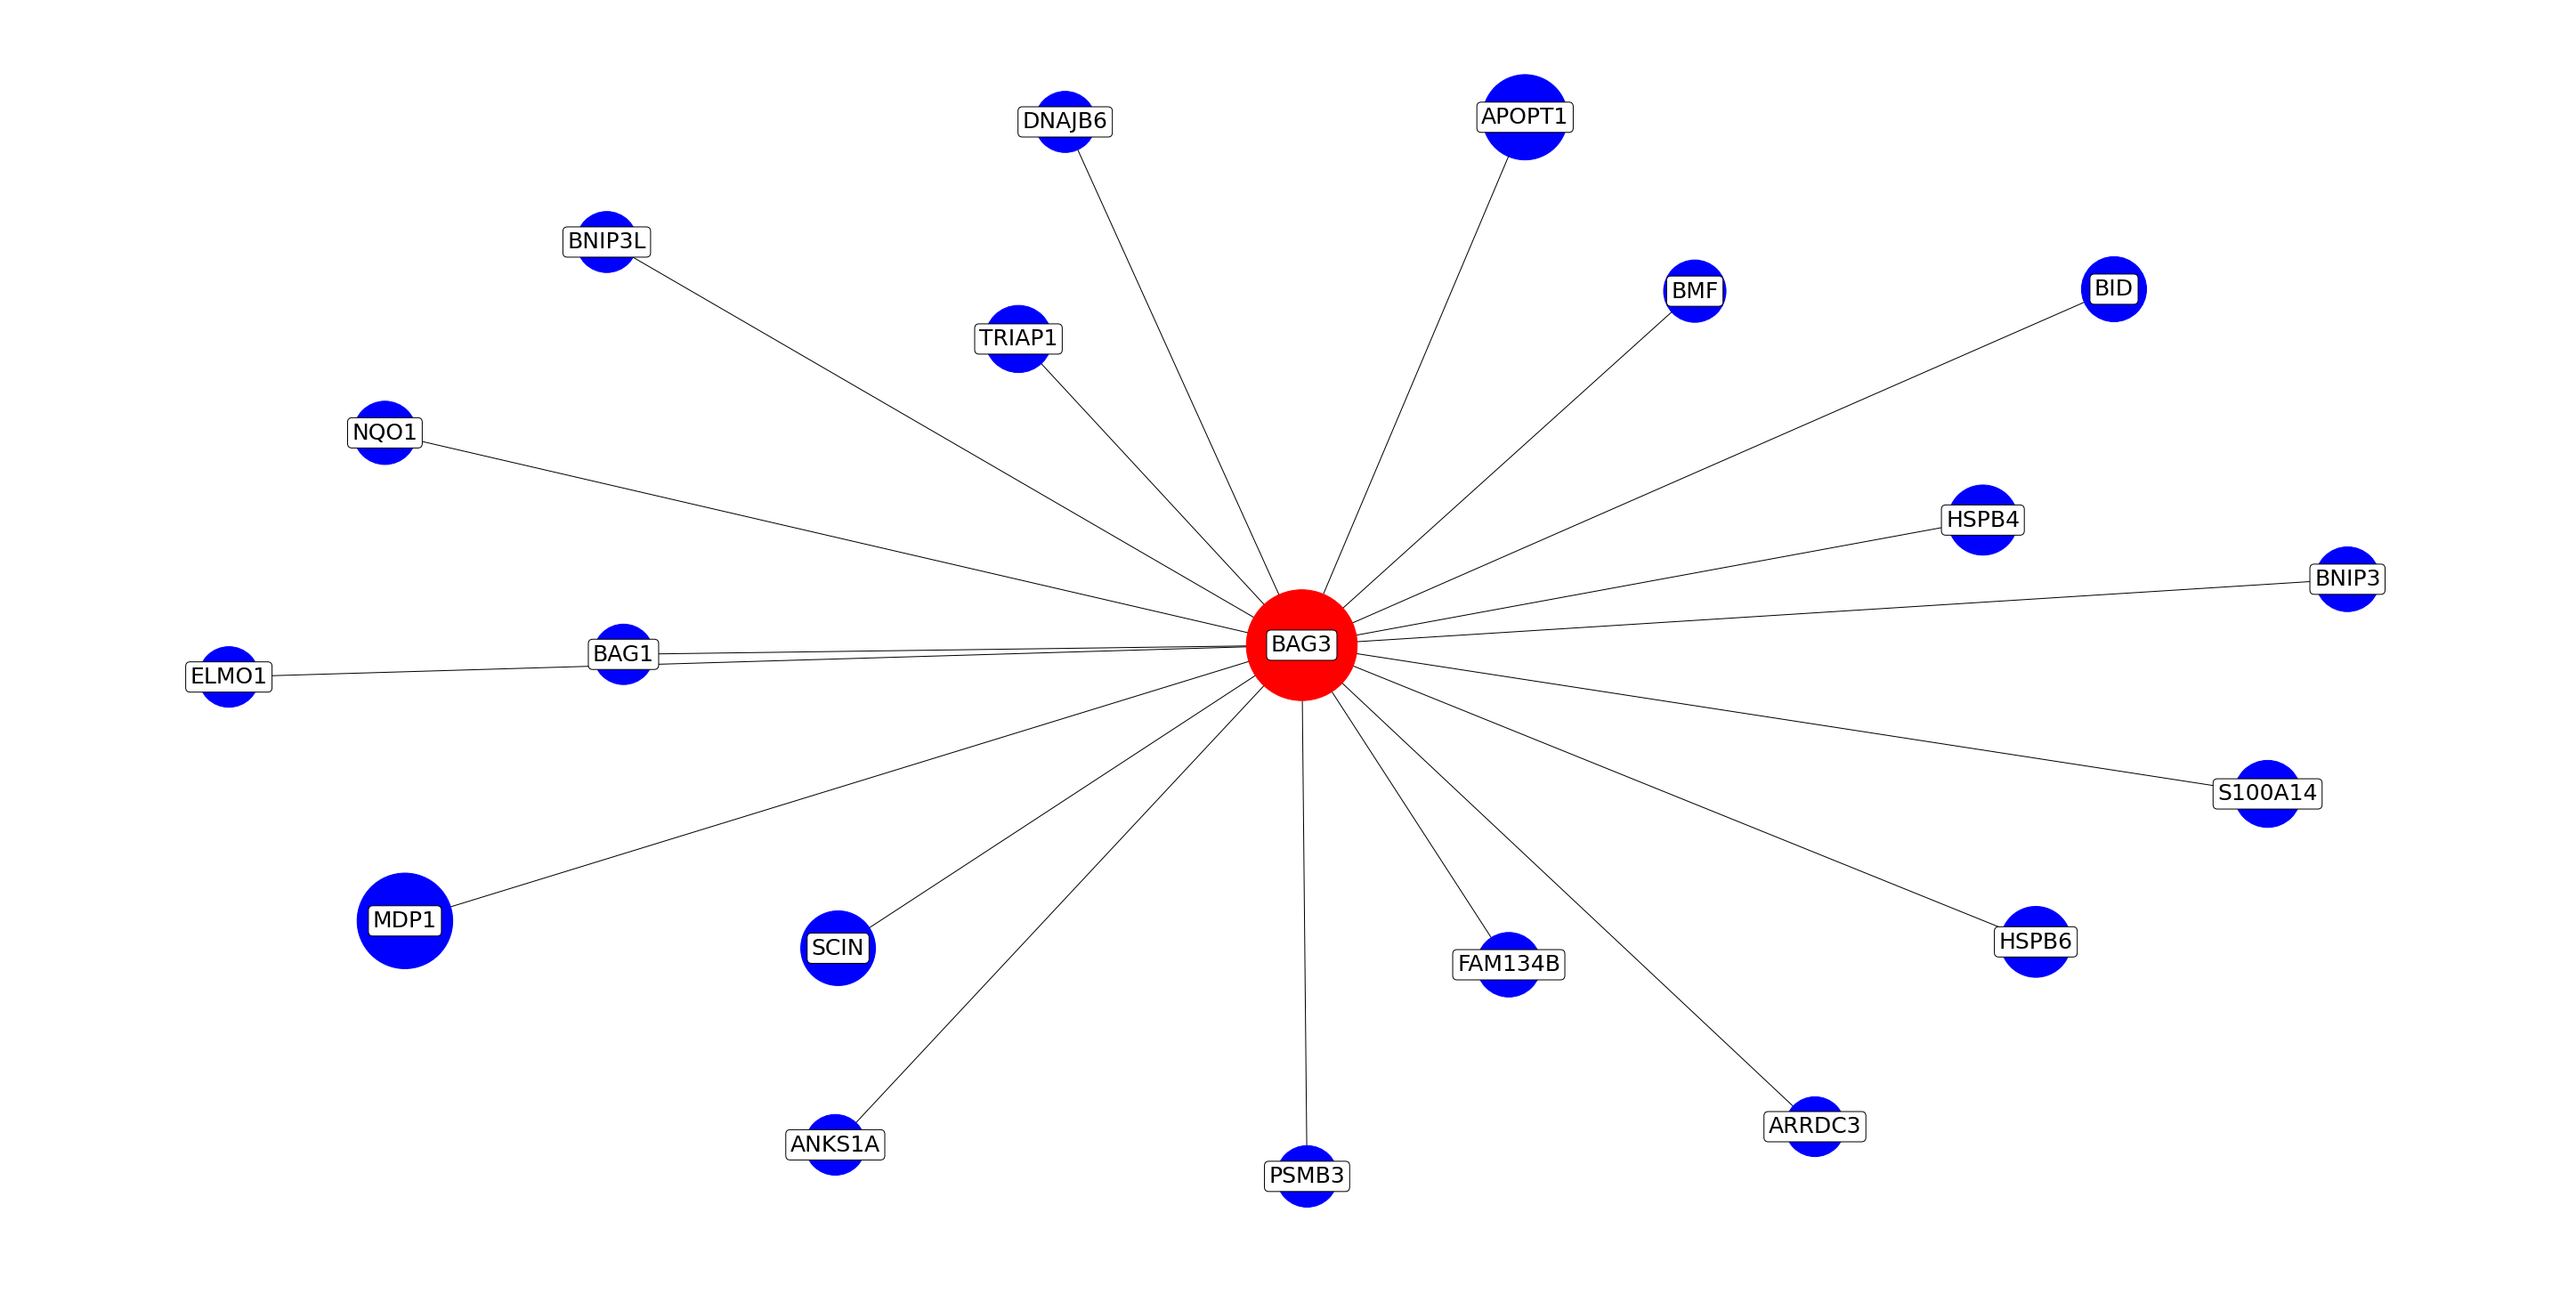

In [28]:
with open("/content/gdrive/MyDrive/Search_protein_keywords/bp_string2.json","r") as f:
    dico_bp=json.load(f)
list_k=list_keyword(list(G.nodes()),dico_bp,go,keyword)
print("taille de la liste: ",len(list_k))
if len(list_k)>0:
  try:
    top_list=top_similar(list_k,model,prot_name,nb_top)
    list_prot=display_shortest_path(prot_name,top_list)
    write_top_list(list_prot,dico_bp,go)

  
  except:
    print("*"*50)
    print("Cet identifiant n'est pas valide ou bien la protéine n'est pas présente dans l'intéractome")
    print("Veuillez saisir un autre identifiant UNIPROT")
    print("*"*50)

else:
  print("*"*50)
  print("Aucun de ces mots clés n'est présent dans les processus biologiques")
  print("Veuillez saisir un autre mot clé")
  print("*"*50)

